# Lending Club Data Set Prediction

In [ ]:
#import warnings
#warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from numpy.random import seed
from scipy.stats import norm
from scipy.stats import ttest_ind_from_stats
df= pd.read_csv('/Users/ankit/Desktop/Springboard dox/Python/LoanStats3a_securev1_new.csv',low_memory=False)


# Understanding the various features (columns) of the dataset


In [ ]:
print(df.info())
df.head()
df.columns

In [ ]:
print(df.shape)

In [ ]:
df.head()

# Data Wrangling

In [ ]:
#rename the column names

df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})


In [ ]:
df.head()
print(type(df['interest_rate'][0]))

In [ ]:
#removing percentage sign from the interest_rate and convert it to float from string
df.interest_rate = df.interest_rate.str.replace('%', '').astype('float64')
print(df.interest_rate.head())

In [ ]:
#remove months from term colums
df.term = df.term.str.replace('months', '')
df.term.head()

In [ ]:
#setting up the index
df.set_index('id')

#member_id column shows Nan value and is of less significance hence we drop it
df.drop(['member_id'],axis=1,inplace=True)

In [ ]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)
missing_fractions.head(20)

In [ ]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (<20%) and those missing "lots" of data (>40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [ ]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(len(drop_list))
df.drop(labels=drop_list, axis=1, inplace=True)
df.shape

So now we dropped the columns with more than 30% missing values and hare left with 58 columns.

In [ ]:
print(df.columns)
df.info()

In [ ]:
df['emp_title'].describe()



There are too many different job titles for this feature to be useful, so we drop it.




In [ ]:
df.drop(labels='emp_title', axis=1, inplace=True)

In [ ]:
df['emp_length'].value_counts(dropna=False).sort_index()

In the above column we need to change the details of 10+ years and <1 year into a readable format which is done below:

In [ ]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

Now we convert hte employee length into an int value :

In [ ]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)
df['emp_length'].value_counts(dropna=False).sort_index()

Because of the large range of incomes, we should take a log transform of the annual income variable.


In [ ]:

df['log_annual_inc'] = df['annual_income'].apply(lambda x: np.log10(x+1))
df['log_annual_inc'].describe()

In [ ]:
df.corr()

In [ ]:
df["loan_status"].value_counts()


In [ ]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

# Pie Chart for Loan Conditions

In [ ]:
#f, ax = plt.subplots(1,2, figsize=(16,8))

labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=15)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.10],autopct='%3.0f%%', shadow=True,labels=labels, fontsize=12, startangle=90)




The above pie chart shows that the data is imbalanced and it has 85% of good loans and 15% of bad loans . We might have to do oversampling of the bad loans for better results at the end . That will be decided after building the model for this data at later stage.

In [ ]:
df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

In [ ]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(14,6))

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)


In [ ]:
#df.corr(loan_status,annual_income)

# Loan Condition V/s Income

In [ ]:
plt.scatter(df.loan_condition,df.annual_income)
plt.xlabel("condition")
plt.ylabel("income")
plt.ylim(0,1400000)
plt.title("Range of income with respect to loan condition")
plt.show()

# Loan Consition V/s Fico Scores

In [ ]:
sns.violinplot(x="fico_range_high", y="loan_condition", data=df, palette="Set2" )
plt.show()

The mean of the good loans is more than 700 and most of the values of fico_score lies near 700 score hence the fico score for good loans should be closer to 700.

In [ ]:
df.home_ownership.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Loan Grades and Subgrades are assigned by Lending Club based on the borrower’s credit worthiness and also on some variables specific to that Loan.

In [ ]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

The majority of loans is either graded as B or C — together these correspond to more than 50% of the loan population.
While there is a considerable amount of A graded or “prime” loans (~17%), there is a small amount of E graded, or “uncollectible” loans (~0,06%). Which is a good sign for Lending Club.
But, are these the right grades?

# More data visualization

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values
sns.distplot(loan_amount, ax=ax[0], color="red",bins=(100,100))
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="blue",bins=(100,100))
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="green",bins=(100,100))
ax[2].set_title("Total committed by Investors", fontsize=14)

In [ ]:
df.boxplot(column='loan_amount')


In [ ]:
mean =np.mean(df.funded_amount)
std =np.std(df.funded_amount)
print(mean)
print(std)

In [ ]:
df.verification_status.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()


In [ ]:
pd.crosstab(df ['verification_status'], df ['loan_condition'], margins=True)


This shows that 41.3% of the bad loans were not verified.

In [ ]:
df[['fico_range_low', 'fico_range_high']].describe()


In [ ]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Number of bad loans were less in the category A jobs and it had more number of good loans as compared to the other category.

  # Statistical Inferences

        # Null hypothesis: The mean interest rates offered for A grade loans are less than the other grades.

In [ ]:
df.interest_rate.groupby(df.grade).value_counts().plot.bar()
plt.show()


In [ ]:
sns.distplot(df.interest_rate[df.grade!='A'].astype('float64').values,color="red")


In [ ]:
def loan_sampler_A(n):
    return np.random.choice(df.interest_rate[df.grade=='A'].astype('float64'), n)
def loan_sampler_other(n):
    return np.random.choice(df.interest_rate[df.grade!='A'].astype('float64'),n)

In [ ]:
seed(47)
size=50
sample1 = loan_sampler_A(size)
sample2 = loan_sampler_other(size)
print(sample1)
type(sample1[0])

In [ ]:
mean_A = np.mean(sample1)
mean_other = np.mean(sample2)
std_A=np.std(sample1)
std_other=np.std(sample2)
seed(47)
N=500
# take your samples here
total_mean_A=np.empty(N)
total_mean_other=np.empty(N)
for i in range (N):
    total_mean_A[i]=np.mean(loan_sampler_A(size))
    total_mean_other[i]=np.mean(loan_sampler_other(size))


In [ ]:
n=len(total_mean_A)
x=np.sort(total_mean_A)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Grade A Loans')
plt.ylabel('ECDF')
plt.show()

In [ ]:
n=len(total_mean_other)
x=np.sort(total_mean_other)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Other Grade Loans')
plt.ylabel('ECDF')
plt.show()

It is very much clear from the above ECDF graph that the interest rates for the other grades lies in the range of (12.5,15)

In [ ]:
from scipy import stats
import scipy.stats
print(stats.ttest_ind(total_mean_other,total_mean_A))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
print("The confidence interval for A grade loans is: "+str(mean_confidence_interval(total_mean_A)))
print("The confidence interval for all other loan other than A grade loans is:"+ str(mean_confidence_interval(total_mean_other)))
           
      

Here, the p value is less than 0.05 hence the result is of high significance.

# Correlation among the features

Few important columns are selected from the full dataset based on the significance and the data present prior to the approval of the loan. The columns are saved in 'imp_columns' list.

Now we will see the correlation between the numerical data

In [ ]:
imp_columns=['loan_amount','term','interest_rate','grade','emp_length','home_ownership','annual_income','verification_status','loan_status','loan_condition','purpose','title','addr_state','fico_range_low','fico_range_high','income_category']
df2=df[imp_columns]
df2.corr()

employee length,annual income and fico scores have strong positive correlation with the loan amount .

In [ ]:
df[imp_columns].head()

Correlation between all the important columns:

In [ ]:
df2.apply(lambda x: x.factorize()[0]).corr()
corr_imp=df2.apply(lambda x: x.factorize()[0]).corr()


In [ ]:
import seaborn as sns

sns.heatmap(corr_imp, 
        xticklabels=corr_imp.columns,
        yticklabels=corr_imp.columns)

# Data Preparation for Model Building

In [ ]:
# Convert all non-numeric values to number
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for var in df.columns:
    le = LabelEncoder()
    df[var]=df[var].astype('str')
    df[var]=le.fit_transform(df[var])
df[imp_columns].dtypes


# Model building

In [ ]:
from sklearn import preprocessing
target_name='loan_condition'
y= df.loan_condition
X= df.drop(target_name,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
y_predict=knn.predict(X_test)
#y_predict=y_predict.reshape(-1,1)

In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

We got an accuracy of 0.93 . As our model has good loans dominating the sample we may need to over sample our data with bad sample.

We would now check the effect on the accuracy by changing n in the model and the graph is plotted below:

In [ ]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
from sklearn.neighbors import KNeighborsClassifier
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


From the above graph we can see that we get best result at n= 4 which gives us training accuracy as 0.96 and testing accuracy as 0.94

# Confusion Matrix

In [ ]:
#Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10000, random_state = 42)
rf.fit(X_train, y_train);
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test,predictions)
print(cm)

#Decision Tree

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm2 = confusion_matrix(y_test,predictions)
print(cm2)

In [ ]:
print (clf_rf.score(X_test, y_test))
print (recall_score(y_test, clf_rf.predict(X_test)))


Imbalanced datasets can be seen everywhere. Usually banks want to predict fraudulent credit card charges but only a small fraction of observations are actually positives. I’d guess that only 1 in 10,000 credit card charges are fraudulent, at most. Recently, oversampling the minority class observations has become a common approach to improve the quality of predictive modeling. By oversampling, models are sometimes better able to learn patterns that differentiate classes.

# Using imblearn for oversampling

In [ ]:
!pip install imblearn


In [ ]:
from imblearn.over_sampling import SMOTE

x_train, x_val, yy_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = .1,
                                                  random_state=123)
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, yy_train)
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=123)
clf_rf.fit(x_train_res, y_train_res)
print ('Validation Results')
print( clf_rf.score(x_val, y_val))
print (recall_score(y_val, clf_rf.predict(x_val)))
print (clf_rf.score(X_test, y_test))
print (recall_score(y_test, clf_rf.predict(X_test)))


We see that the recall score and precision score comes out to be 1, which does not seen to be right. it can also be because of the dominating class of good loans or some other dominating features.

We can use check the important features in the model:

In [634]:
!pip install tabulate


  Using cached https://files.pythonhosted.org/packages/66/d4/977fdd5186b7cdbb7c43a7aac7c5e4e0337a84cb802e154616f3cfc84563/tabulate-0.8.5.tar.gz
  Stored in directory: /Users/ankit/Library/Caches/pip/wheels/e1/41/5e/e201f95d90fc84f93aa629b6638adacda680fe63aac47174ab
Successfully built tabulate


In [635]:
from tabulate import tabulate
model = clf_rf.fit(X_train, y_train)
headers = ["name", "score"]
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                              score
loan_status                 0.281725
loan_condition_int          0.273198
recoveries                  0.225039
collection_recovery_fee     0.120456
last_credit_pull_d          0.0258278
last_fico_range_low         0.0220151
last_fico_range_high        0.0217922
total_rec_late_fee          0.00312538
funded_amount               0.00264734
total_rec_prncp             0.00251706
sub_grade                   0.00244401
debt_settlement_flag        0.00231675
grade                       0.00168734
loan_amount                 0.00159987
interest_rate               0.00154694
term                        0.00137368
investor_funds              0.00127642
total_rec_int               0.00107401
installment                 0.000915142
total_pymnt                 0.000866923
last_pymnt_d                0.000742396
total_pymnt_inv             0.000717986
fico_range_low              0.000619525
last_pymnt_amnt             0.000614174
fico_range_high             0

We can see that few features such as:
loan_status,loan_condition_int,recoveries,collection_recovery_fee,last_credit_pull_d,total_rec_late_fee,total_rec_int,installment,total_pymnt,last_pymnt_d,total_pymnt_inv are to be dropped due to there insignificance/unavailability before the approval or similar terms to the loan_condition(target variable).

Hence we drop the above columns from the new data set and train our model again.

In [644]:
delete=['loan_status','loan_condition_int','recoveries','collection_recovery_fee','last_credit_pull_d','total_rec_late_fee','total_rec_int','installment','total_pymnt','last_pymnt_d','total_pymnt_inv']
df=df.drop(delete,axis=1,inplace=True)
df['loan_condition']

AttributeError: 'NoneType' object has no attribute 'drop'

In [643]:
target_name='loan_condition'
y= df.loan_condition
X= df.drop(target_name,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)
x_train, x_val, yy_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = .3,
                                                  random_state=123)
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, yy_train)
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=123)
clf_rf.fit(x_train_res, y_train_res)
print ('Validation Results')
print( clf_rf.score(x_val, y_val))
print (recall_score(y_val, clf_rf.predict(x_val)))
print (clf_rf.score(X_test, y_test))
print (recall_score(y_test, clf_rf.predict(X_test)))


AttributeError: 'NoneType' object has no attribute 'loan_condition'

##### The above liberary does not give a very satisfactory result as we are unaware as how the data has been split, i.e., what is the ratio of good v/s bad loans in the new data set. Hence, we will try to do it manually below. 

# Creating a Balanced Dataset Manually

In [ ]:
bad_loans=df[df.loan_condition.values=='Bad Loan']
good_loans=df[df.loan_condition.values=='Good Loan'][:int(bad_loans.shape[0]*0.66)]

It shows that out of 43000 datasets 6431 data represents the bad loans . So to make our dataset balanced we will create a new dataset "balanced" coprising both the type in 3:2 ratio

In [371]:
balanced_df=pd.concat([bad_loans,good_loans])
balanced_df.shape

(10675, 61)

In [380]:
# Convert all non-numeric values to number
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for var in balanced_df.columns:
    le = LabelEncoder()
    balanced_df[var]=balanced_df[var].astype('str')
    balanced_df[var]=le.fit_transform(balanced_df[var])
df[imp_columns].dtypes


loan_amount            int64
term                   int64
interest_rate          int64
grade                  int64
emp_length             int64
home_ownership         int64
annual_income          int64
verification_status    int64
loan_status            int64
loan_condition         int64
purpose                int64
title                  int64
addr_state             int64
fico_range_low         int64
fico_range_high        int64
income_category        int64
dtype: object

### Now we will use the above balanced data set to run and improve our model 

Wewill be using two models separately to plot the ROC curve using the manually over sampled data.The two models to be used are:


1) KNN Classifier
  2)Logistic Regression

In [381]:
#knn Classifier
from sklearn import preprocessing
target_name='loan_condition'
y1= balanced_df['loan_condition']
X1= balanced_df.drop(target_name,axis=1)


In [545]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, random_state=123)
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X1_train, y1_train)
y1_predict=knn.predict(X1_test)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y1_test, y1_predict))



Accuracy: 0.9704008992131885


In [547]:
recall_score(y1_test,y1_predict)

0.9858623939679547

In [549]:
from sklearn.metrics import classification_report
print(classification_report(y1_test, knn.predict(X1_test), digits=4))


              precision    recall  f1-score   support

           0     0.9904    0.9602    0.9751      1608
           1     0.9423    0.9859    0.9636      1061

    accuracy                         0.9704      2669
   macro avg     0.9664    0.9730    0.9693      2669
weighted avg     0.9713    0.9704    0.9705      2669



In [550]:
fpr, tpr, thresholds = metrics.roc_curve(y1_test, y1_predict)


In [551]:
print("False Positive Rate"+str(fpr))
print("True Positive Rate"+str(tpr))
print("Treshold"+str(thresholds))

False Positive Rate[0.       0.039801 1.      ]
True Positive Rate[0.         0.98586239 1.        ]
Treshold[2 1 0]


In [552]:
roc_auc=metrics.auc(fpr, tpr)


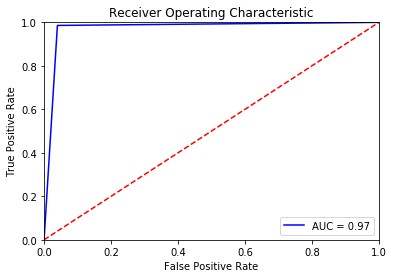

In [554]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Using Logistic Regression for the above balanced dataset

In [556]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
X_lr_train,X_lr_test,y_lr_train,y_lr_test=train_test_split(X1, y1, random_state=123)


In [557]:
lr.fit(X_lr_train, y_lr_train)


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [558]:
print(lr.coef_)
print(lr.intercept_)

[[-2.10671398e-04 -3.42014457e-03  1.39804735e-03  1.03481809e-03
   2.88742917e-03  4.05275527e-03  2.05293649e-04 -2.37021682e-02
  -1.26997560e-01  6.26722007e-02  5.58580144e-03  1.63210652e-05
   3.61583871e-02  5.58924110e-02  2.98285186e-01  0.00000000e+00
  -2.10671398e-04 -4.27952532e-02  2.36055850e-05  9.08388742e-04
   2.04235781e-02 -4.69971260e-05  1.06706428e-02  1.37211633e-03
  -4.01512802e-02 -4.01512802e-02 -6.63302572e-02  1.26898846e-02
  -1.16410195e-02 -4.09330406e-05  8.88410954e-04  1.68807202e-04
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.45928889e-04
   3.12334692e-04 -2.69723532e-04  1.64192126e-04 -2.00459381e-03
  -5.48670180e-01 -4.13800436e-03 -7.84064812e-03  1.24715499e-04
  -5.11390544e-03  3.66105260e-02  3.01449194e-02 -2.80769954e-03
   0.00000000e+00  0.00000000e+00 -2.18216813e-10 -2.80769954e-03
  -2.18216813e-10 -5.98442340e-02 -1.94509236e-04  0.00000000e+00
  -2.21067665e-02  6.82650279e-04  1.89119907e-02 -1.52310156e-01]]
[0.00690

In [559]:
y_lr_pred = lr.predict(X_lr_test)


In [560]:
confusion_matrix(y_lr_test, y_lr_pred)


array([[1603,   17],
       [   2, 1047]])

In [561]:
recall_score(y_lr_test, y_lr_pred, average='macro')  


0.9937997975732326

In [562]:
from sklearn.metrics import precision_score

precision_score(y_lr_test, y_lr_pred, average='macro')  


0.9913882252359871

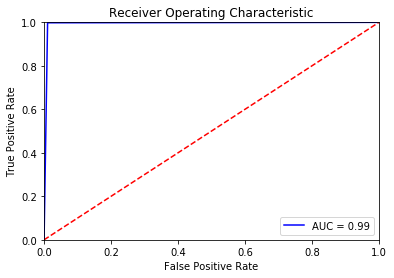

False Positive Rate[0.         0.01049383 1.        ]
True Positive Rate[0.         0.99809342 1.        ]
Treshold[2 1 0]


In [563]:
fpr, tpr, thresholds = metrics.roc_curve(y_lr_test, y_lr_pred)
roc_auc=metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("False Positive Rate"+str(fpr))
print("True Positive Rate"+str(tpr))
print("Treshold"+str(thresholds))

### We will be proceeding for an Ensembled Learning Model and hence we will now observe the performance of Six models together using a FOR loop.

The six models used below are:
    
1)LogisticRegression


2)DecisionTreeClassifier


3)LinearDiscriminantAnalysis


4)SVC


5)KNeighborsClassifier


6)MultinomialNB


#### Six models on the balanced data:

In [701]:
from sklearn.model_selection import train_test_split
train_X,val_X,train_y,val_y=train_test_split(X1_train,y1_train,random_state=123)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
models=[]
models.append(("logreg",LogisticRegression()))
models.append(("tree",DecisionTreeClassifier()))
models.append(("lda",LinearDiscriminantAnalysis()))
models.append(("svc",SVC()))
models.append(("knn",KNeighborsClassifier()))
models.append(("nb",MultinomialNB()))
seed=123
scoring='accuracy'
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
result=[]
names=[]
for name,model in models:
    #print(model)
    kfold=KFold(n_splits=10,random_state=seed)
    model.fit(train_X,train_y)
    y1_predict=model.predict(val_X)
    cv_result=cross_val_score(model,train_X,train_y,cv=kfold,scoring=scoring)
    result.append(cv_result)
    names.append(name)
    print("Results on the Test Data: %s %f %f %f %f" % (name,cv_result.mean(),cv_result.std(),recall_score(y1_test, model.predict(X1_test), average='macro'),precision_score(y1_test, model.predict(X1_test), average='macro')))  
    print("Results on the Validation data: %f %f" % (recall_score(val_y, model.predict(val_X), average='macro'),precision_score(val_y, model.predict(val_X), average='macro')))


Results on the Test Data:/n logreg 0.995336 0.002667 0.994092 0.991204
Resukts on the Validation data: 0.996206 0.994545
Results on the Test Data:/n tree 1.000000 0.000000 1.000000 1.000000
Resukts on the Validation data: 1.000000 1.000000
Results on the Test Data:/n lda 0.998834 0.001500 0.999689 0.999529
Resukts on the Validation data: 0.999157 0.998778
Results on the Test Data:/n svc 0.605763 0.022685 0.500000 0.301236
Resukts on the Validation data: 0.500000 0.296204
Results on the Test Data:/n knn 0.963023 0.005371 0.969440 0.962345
Resukts on the Validation data: 0.965244 0.957305
Results on the Test Data:/n nb 0.907896 0.009847 0.897022 0.899817
Resukts on the Validation data: 0.896460 0.903104


It seems like except for the SVC model all other models agree to each other.Hence we will finally use Ensemble Model as our main aim is to increase the Precision(decrease the False Positives which are more dangerous in our case).


# Ensemble Model